In [1]:
!pip install -qq arff2pandas
!pip install -q -U watermark
!pip install -qq -U pandas

import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p

In [2]:
#pip install --upgrade pandas

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


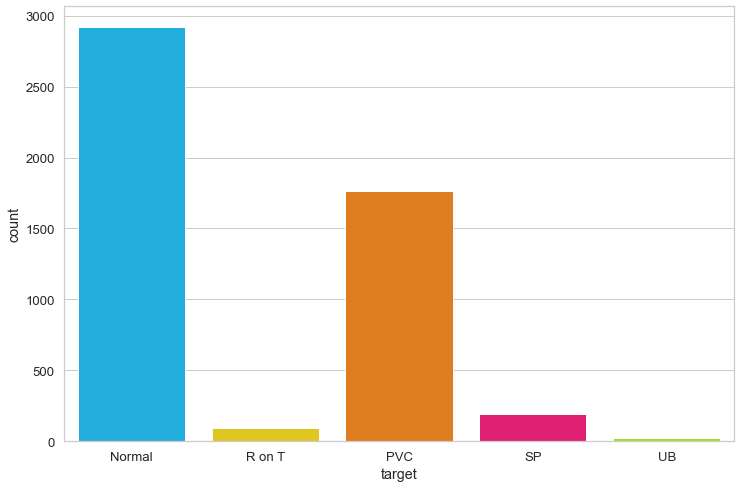

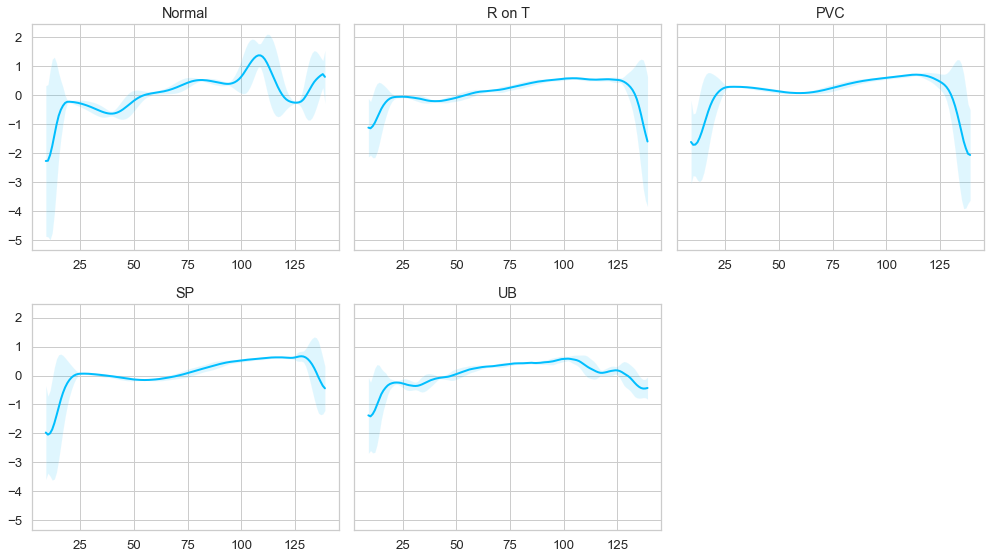

Epoch 1: train loss 75.91648677163238 val loss 68.03929847743323
Epoch 2: train loss 68.19707075255093 val loss 68.89112984198353
Epoch 3: train loss 61.04383442796848 val loss 52.85693464832501
Epoch 4: train loss 52.18316219795716 val loss 52.156850860387394
Epoch 5: train loss 50.44942009713274 val loss 49.844851510109756
Epoch 6: train loss 48.38650738102253 val loss 45.45742271215029
Epoch 7: train loss 43.64992303629164 val loss 42.65399504521601
Epoch 8: train loss 41.11311687744706 val loss 41.280514674788854
Epoch 9: train loss 40.08824743680635 val loss 43.07958148526657
Epoch 10: train loss 39.79684500673133 val loss 38.587074943776834
Epoch 11: train loss 39.48111359220702 val loss 40.92828573545905
Epoch 12: train loss 38.868607759764004 val loss 40.167034058033806
Epoch 13: train loss 38.4352135233512 val loss 39.987267972666245
Epoch 14: train loss 38.4112941937214 val loss 37.87443972773112
Epoch 15: train loss 38.13644500126622 val loss 38.61944772114933
Epoch 16: trai

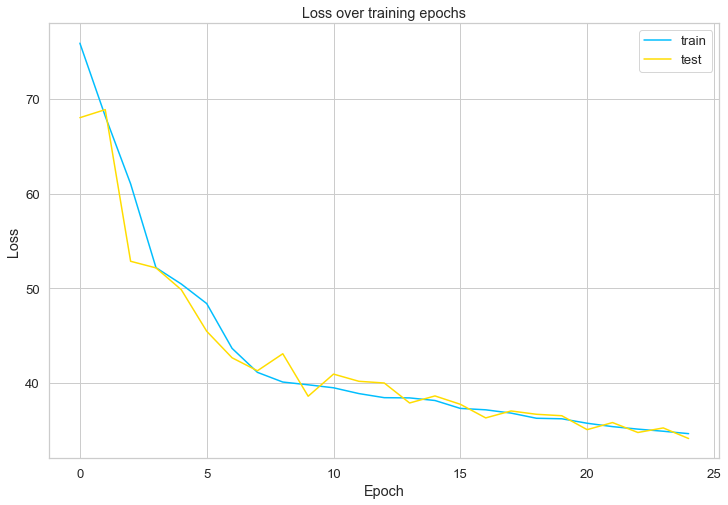

In [25]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

"""
In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. 
You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

# Data
The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)
"""

#Load the arff files into Pandas data frames / Change Path as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

#We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:"""

df = train.append(test)
df = df.sample(frac=1.0)
df.shape

df.head()

"""We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:"""

CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

"""Next, we'll rename the last column to `target`, so its easier to reference it:"""

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

"""## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:
"""

df.target.value_counts()

"""Let's plot the results:"""

ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

"""The normal class, has by far, the most examples. 

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:
"""

def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();
plt.show()
## LSTM Autoencoder

### Data Preprocessing

#Let's get all normal heartbeats and drop the target (class) column:

normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

#Merge all other classes and mark them as anomalies:"""

anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

#Split the normal examples into train, validation and test sets:"""

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

#Convert our examples into tensors, so we can use them to train our Autoencoder. 

def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

#Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

#Create Train, Val and Test datasets:

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

# LSTM Autoencoder
#The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    #self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.embedding_dim, self.hidden_dim = embedding_dim, embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    #x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn1(x)
    #x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

"""The *Encoder* uses LSTM layers to compress the Time Series data input.
Next, we'll decode the compressed representation using a *Decoder*:
"""

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    # self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.hidden_dim, self.n_features = input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim, 
      num_layers=1, 
      batch_first=True
    )

    # self.rnn2 = nn.LSTM(
    #   input_size=input_dim,
    #   hidden_size=self.hidden_dim,
    #   num_layers=1,
    #   batch_first=True
    # )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    #x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

#Our Decoder contains LSTM layer and an output layer that gives the final reconstruction.

#Time to wrap everything into an easy to use module:


class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

"""Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:"""

#model = RecurrentAutoencoder(seq_len, n_features, 128)
#model = RecurrentAutoencoder(seq_len, n_features, 8)
model = RecurrentAutoencoder(seq_len, n_features, 6)
model = model.to(device)

"""## Training

Let's write a helper function for our training process:
"""

def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

"""At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:
"""

model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=25
#  n_epochs=25  
)

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

## Saving the model

#Let's store the model for later use:


MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


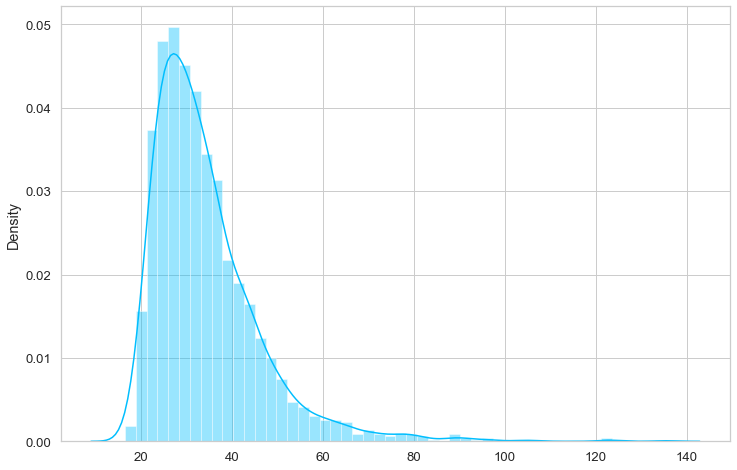

In [26]:
"""## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:
"""

def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

"""Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:"""

_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct normal predictions: 128/145


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Correct anomaly predictions: 143/145


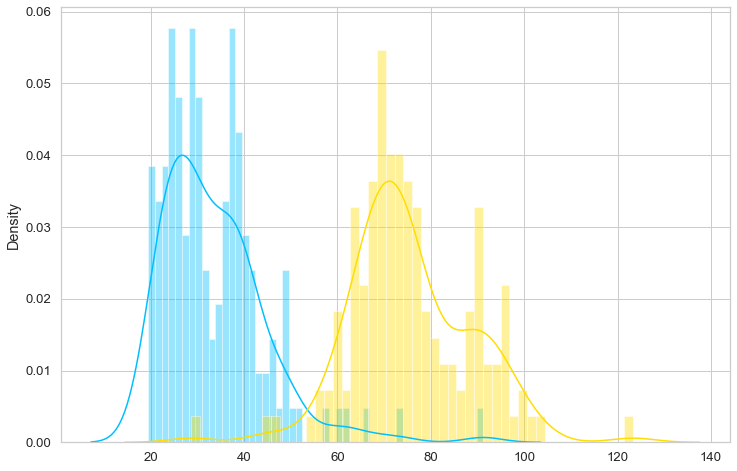

In [27]:
THRESHOLD = 45

"""## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):
"""

predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

"""We'll count the correct predictions:"""

correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

"""### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:
"""

anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
#anomaly_dataset = test_anomaly_dataset
"""Now we can take the predictions of our model for the subset of anomalies:"""

predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

"""Finally, we can count the number of examples above the threshold (considered as anomalies):"""

correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')